# [POC] Labour Progression Regression w Scikit-learn

This dataset contains **2126** records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

1. Normal
2. Suspect
3. Pathological

The dataset is obtained from [Kaggle.com](https://www.kaggle.com/), an online machine learning community.

Link to the dataset is [Here](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification?resource=download)

## **1. Importing Packages**

In [85]:
# General Python imports
import os
import gc
import time
import tqdm
import random

os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
from itertools import cycle

# Visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')     

# Machine Learning libraries
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score

In [5]:
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        if filename == "fetal_health_labour_progression.csv":
            FILE_PATH = os.path.join(dirname, filename)
            print(FILE_PATH)

input/fetal_health_labour_progression.csv


## **2. Config**

In [39]:
RANDOM = random.randint(0, 100)

TEST_SIZE = 0.20
VAL_SIZE = 0.15

EPOCHS = 100
BATCH_SIZE = 4

## **3. Data**

### 3.1 Loading the Data

In [7]:
data = pd.read_csv(FILE_PATH)
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health,labour_progression
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0,-0.263977
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0,1.954458
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0,1.971485
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0,2.222056
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0,1.785438


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 23 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,1.333039e+02,9.840844,106.000000,126.000000,133.000000,140.000000,160.000000
accelerations,2126.0,3.178269e-03,0.003866,0.000000,0.000000,0.002000,0.006000,0.019000
fetal_movement,2126.0,9.480715e-03,0.046666,0.000000,0.000000,0.000000,0.003000,0.481000
uterine_contractions,2126.0,4.366416e-03,0.002946,0.000000,0.002000,0.004000,0.007000,0.015000
light_decelerations,2126.0,1.889464e-03,0.002960,0.000000,0.000000,0.000000,0.003000,0.015000
severe_decelerations,2126.0,3.292568e-06,0.000057,0.000000,0.000000,0.000000,0.000000,0.001000
prolongued_decelerations,2126.0,1.585136e-04,0.000590,0.000000,0.000000,0.000000,0.000000,0.005000
abnormal_short_term_variability,2126.0,4.699012e+01,17.192814,12.000000,32.000000,49.000000,61.000000,87.000000
mean_value_of_short_term_variability,2126.0,1.332785e+00,0.883241,0.200000,0.700000,1.200000,1.700000,7.000000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660e+00,18.396880,0.000000,0.000000,0.000000,11.000000,91.000000


### 3.2 Data Analysis

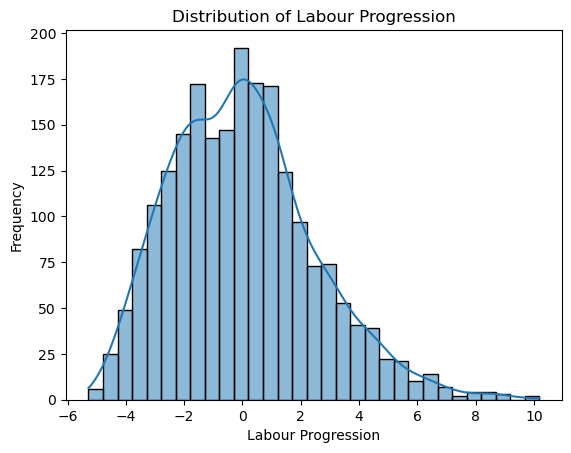

In [14]:
sns.histplot(data['labour_progression'], kde=True)  # histplot for distribution
plt.title('Distribution of Labour Progression')
plt.xlabel('Labour Progression')
plt.ylabel('Frequency')
plt.show()

The count plot of targets indicates an imbalance in data. This is a case that tends to provide misleading compute accuracy.


<Axes: >

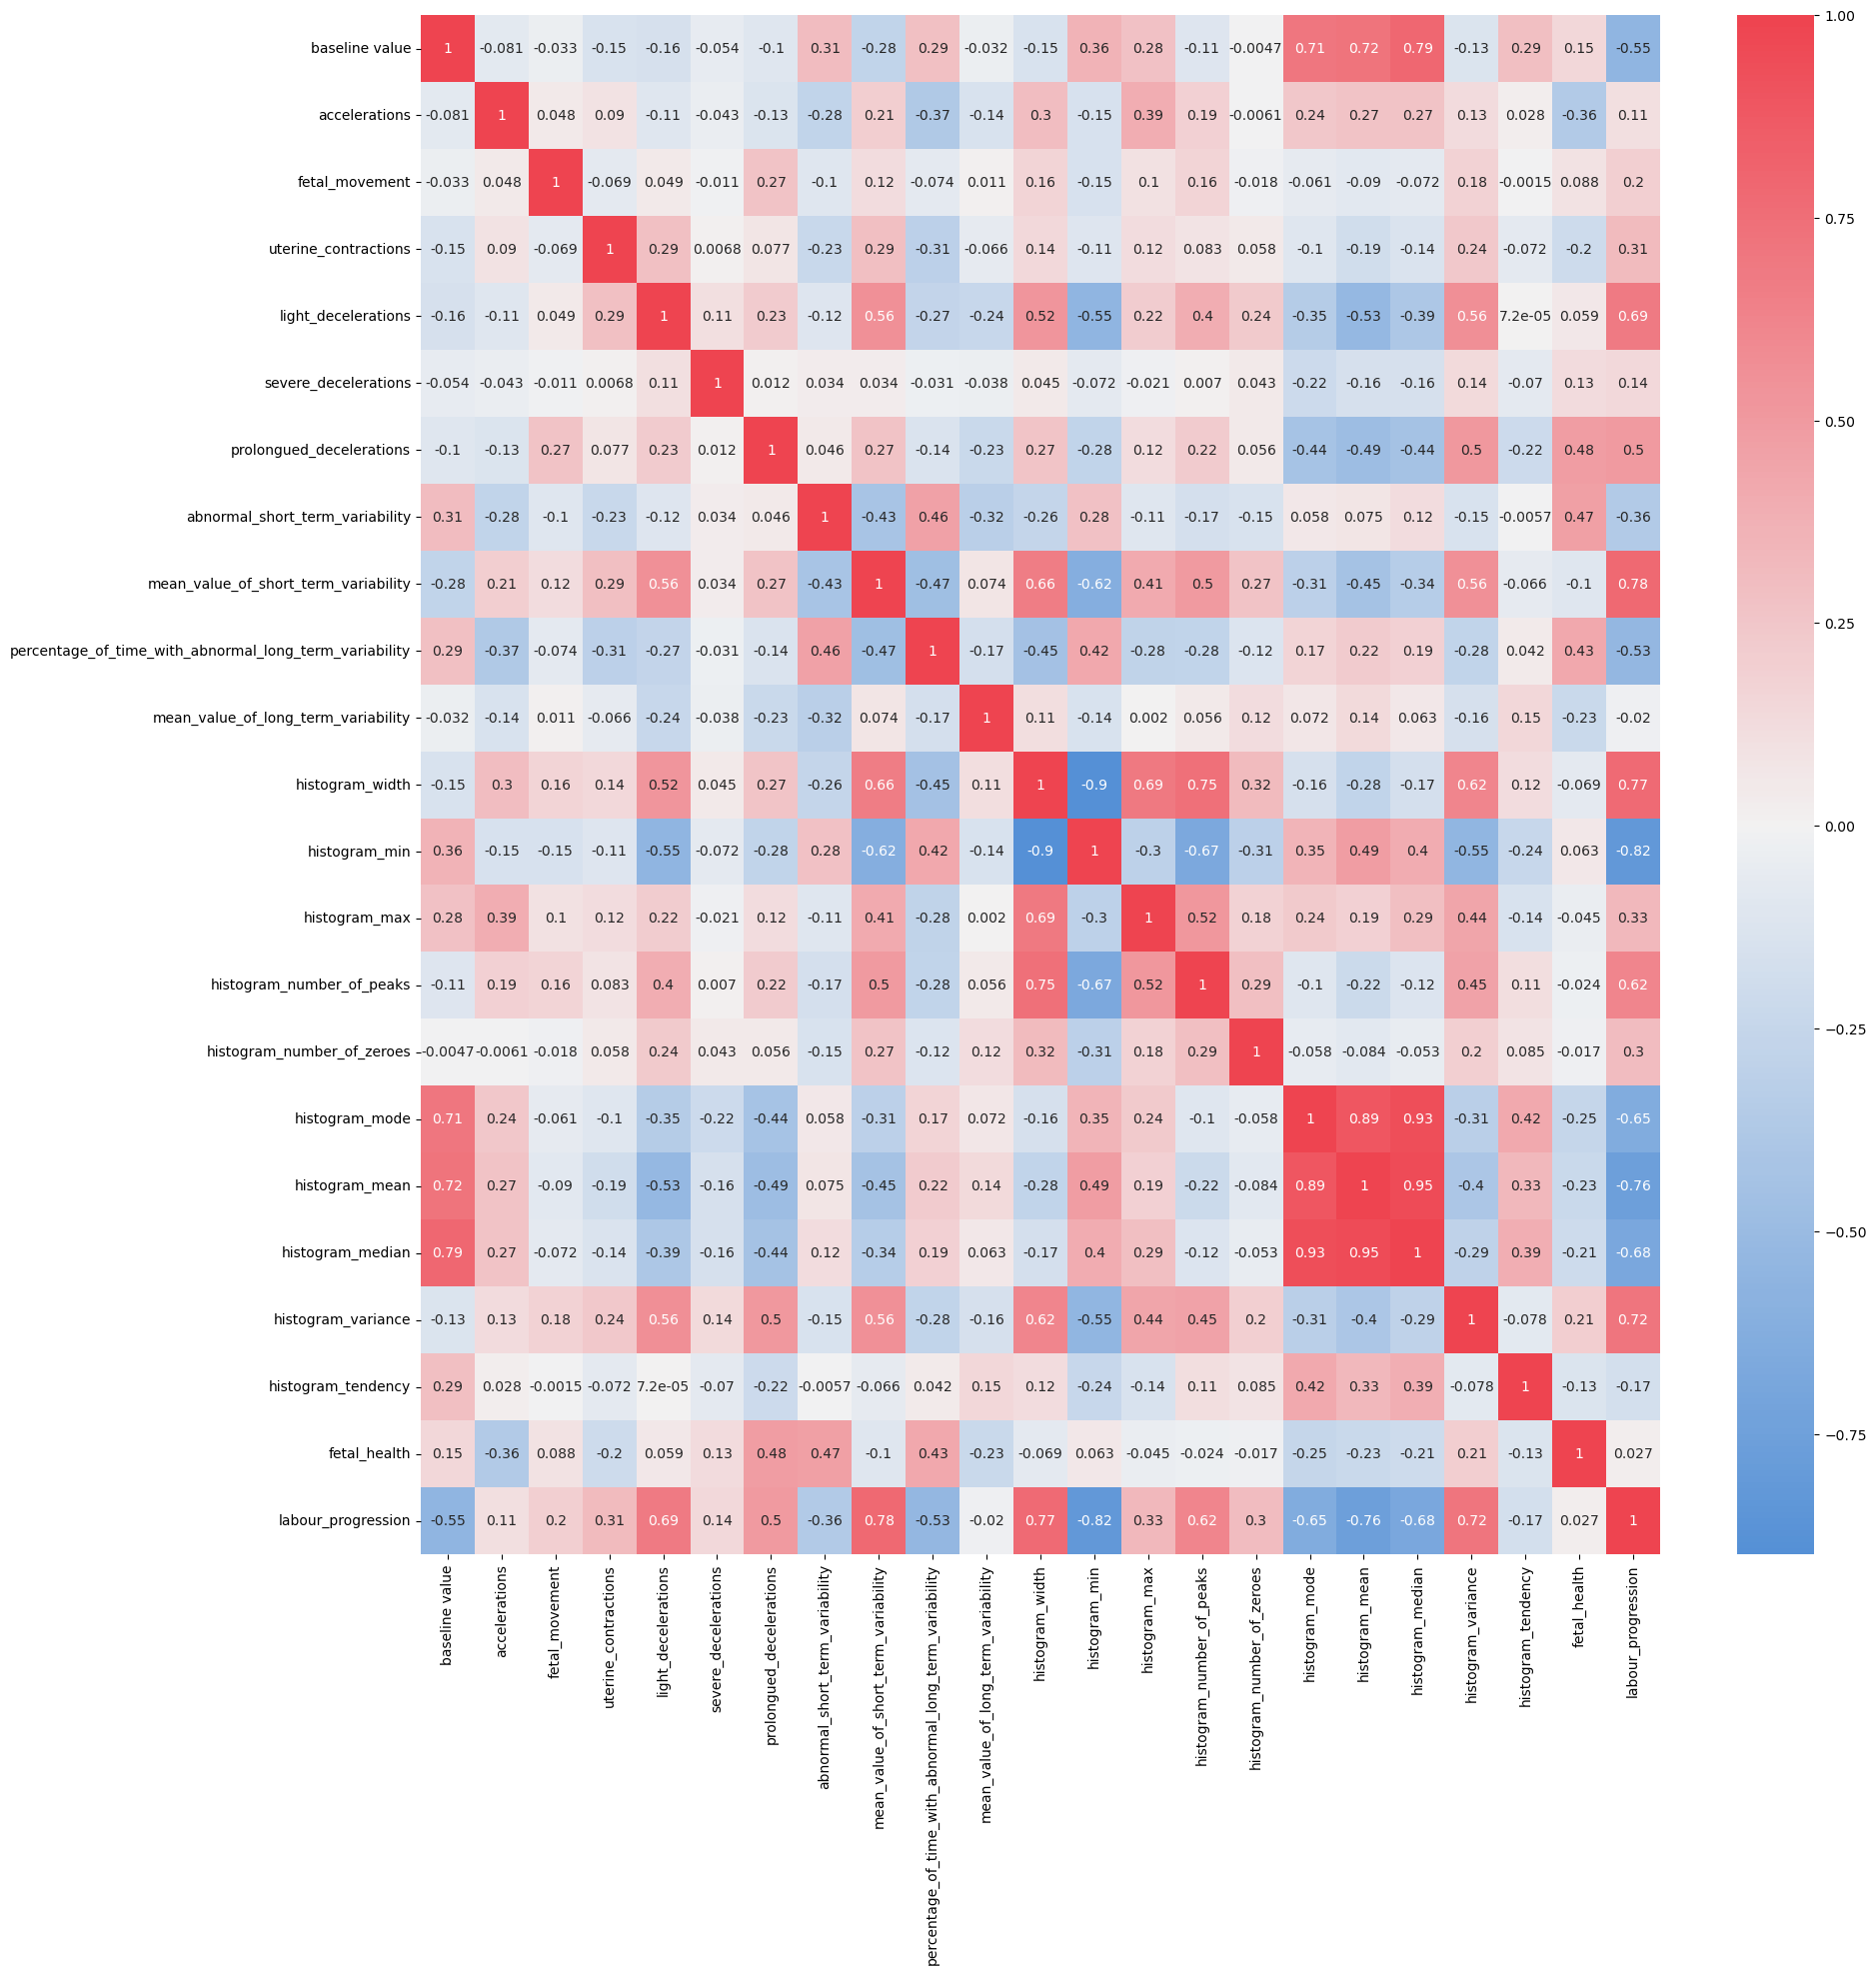

In [17]:
# Correlation matrix
corrmat= data.corr()
plt.figure(figsize=(20,20))  

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)

sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

Based on the correlation matix, we can infer that
1. light_deceleration
2. prolonged_deceleration
3. mean_value_of_short_term_variability
4. histogram_number_of_peaks
5. histogram_variance


are the features with higher correlation with labour progression.

### 3.3 Correlation with Labour Progression

**1. Light Deceleration**

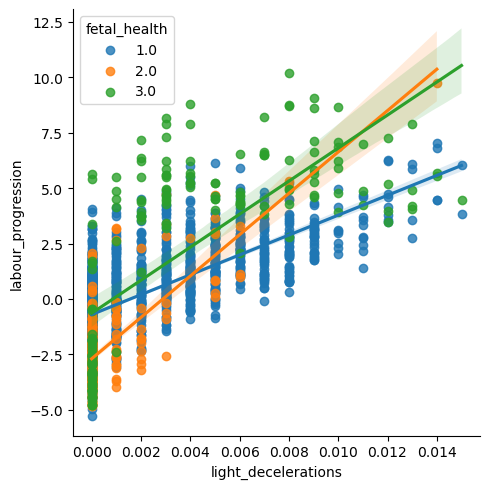

In [19]:
sns.lmplot(data=data, x="light_decelerations", y="labour_progression", hue="fetal_health", legend_out=False)
plt.show()

**2. Prolonged Decelerations**

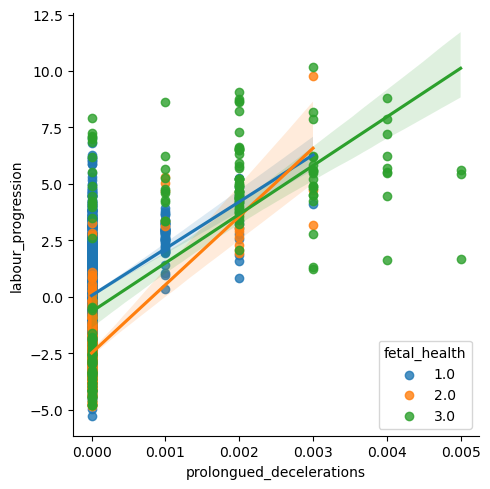

In [20]:
sns.lmplot(data=data, x="prolongued_decelerations", y="labour_progression", hue="fetal_health", legend_out=False)
plt.show()

**3. Mean Value of Short Term Variability**

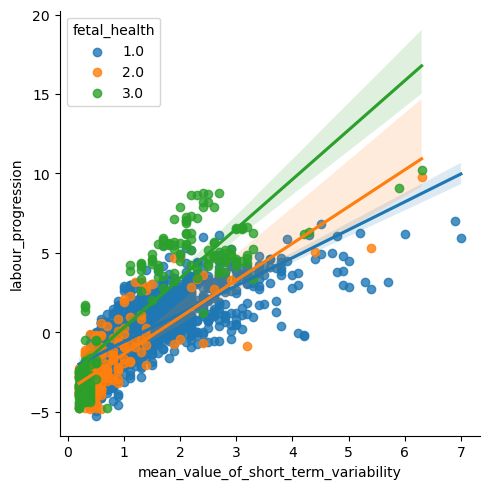

In [21]:
sns.lmplot(data=data, x="mean_value_of_short_term_variability", y="labour_progression", hue="fetal_health", legend_out=False)
plt.show()

**4. Histogram: Number of Peaks**

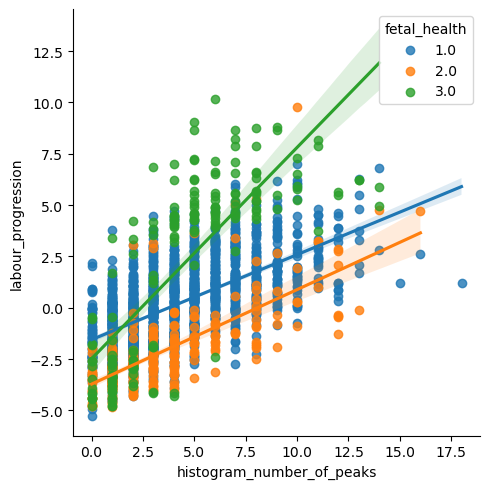

In [22]:
sns.lmplot(data=data, x="histogram_number_of_peaks", y="labour_progression", hue="fetal_health", legend_out=False)
plt.show()

**5. Histogram Variance**

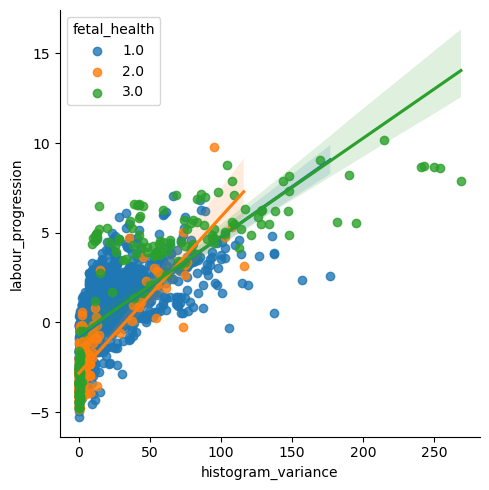

In [24]:
sns.lmplot(data=data, x="histogram_variance", y="labour_progression", hue="fetal_health", legend_out=False)
plt.show()

### 3.5 Feature Scaling

We can clearly spot some outliers in our dataset. However, it is not quite a good idea to remove them yet as it may lead to overfitting. Though we may end up with better statistics.

A basic rule of thumb for the outliers in question is:
* It is a measurement error or data entry error, correct the error if possible. If you can’t fix it, remove that observation. In our case, this is the outcome of a CTG report so it is unlikely that this was a data entry error.
* If it is not a part of the population you are studying, you can legitimately remove the outlier. In this case, this all is about the fetus, and experts tag the classification. Let's stick with the expert opinion.

Thus assuming that these are the natural part of the population we are studying, we should not remove it.

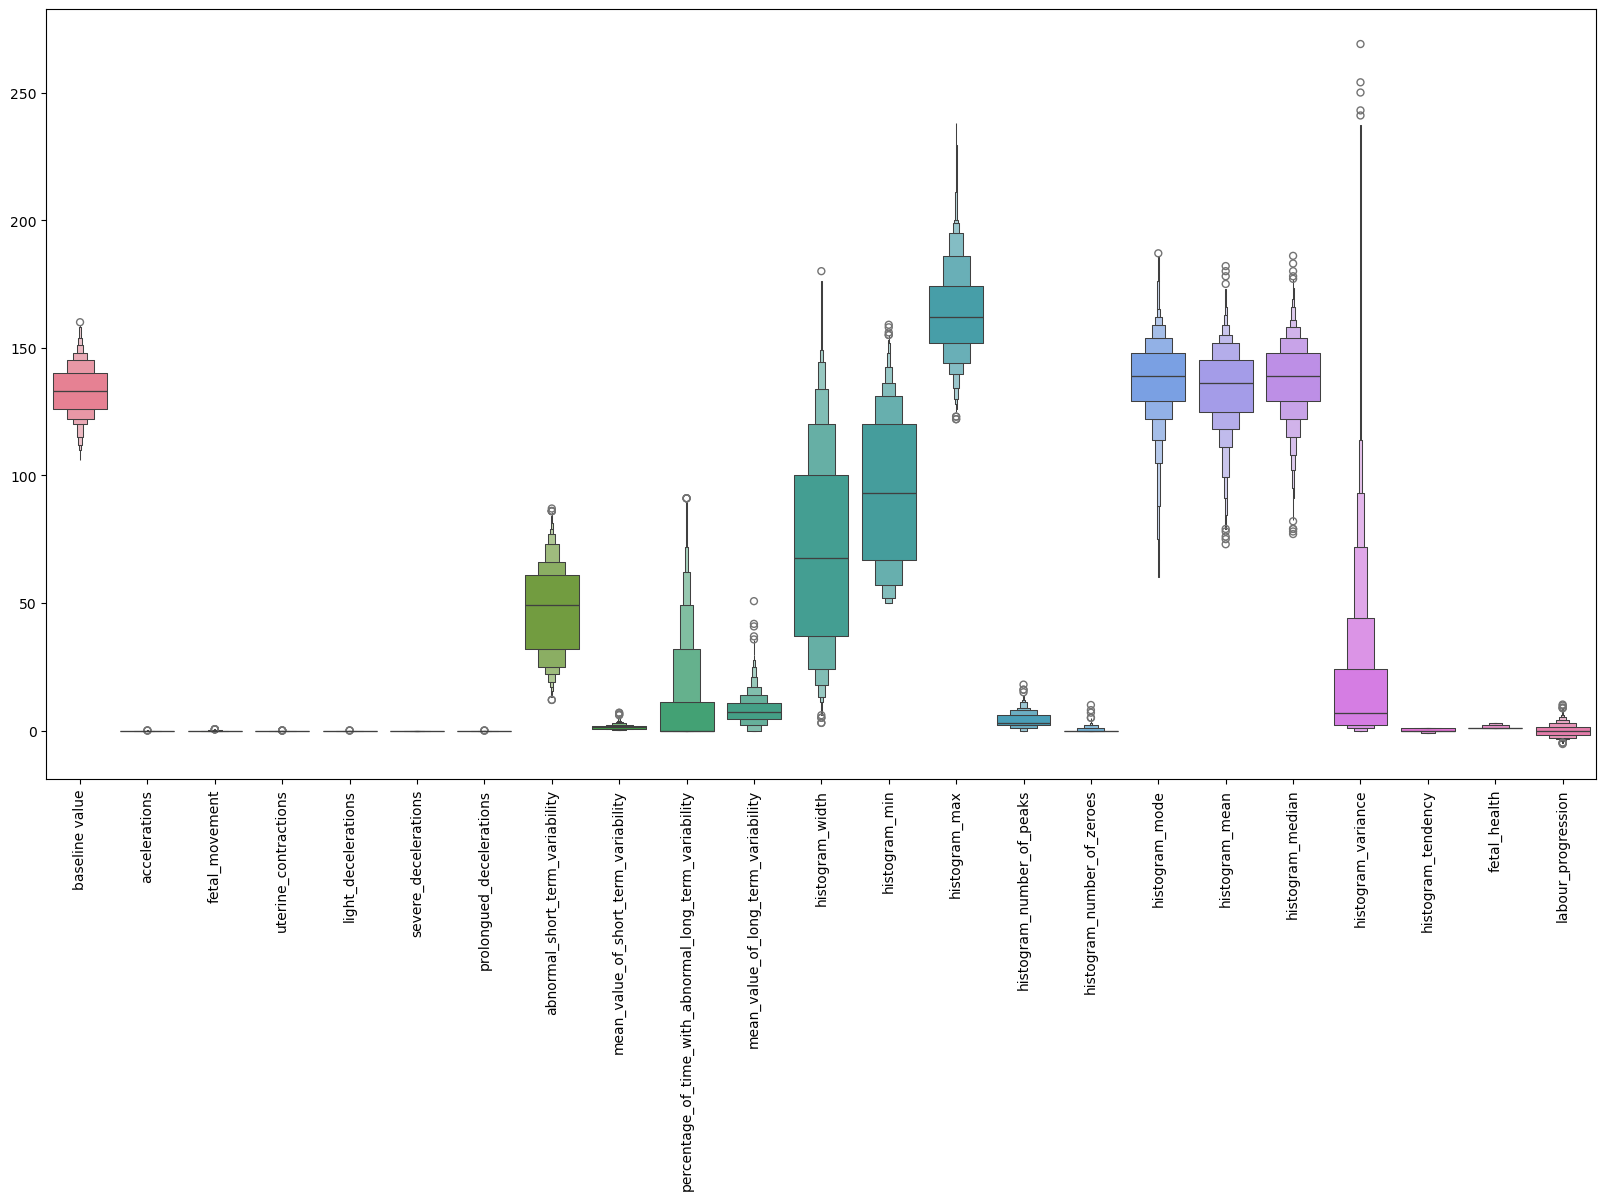

In [27]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = data)
plt.xticks(rotation=90)
plt.show()

The above plot shows the range of our feature attributes.

All the features are in different ranges. To fit this in a model we must scale it to the same range. -> StandardScaler

In [30]:
X = data.drop(["labour_progression", "fetal_health"],axis=1)
y = data["labour_progression"]

#Set up a standard scaler for the features
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)   
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,1.069490e-15,1.000235,-2.775197,-0.742373,-0.030884,0.680604,2.713428
accelerations,2126.0,-4.010589e-17,1.000235,-0.822388,-0.822388,-0.304881,0.730133,4.093929
fetal_movement,2126.0,-1.336863e-17,1.000235,-0.203210,-0.203210,-0.203210,-0.138908,10.106540
uterine_contractions,2126.0,-1.336863e-16,1.000235,-1.482465,-0.803434,-0.124404,0.894142,3.610264
light_decelerations,2126.0,-5.347452e-17,1.000235,-0.638438,-0.638438,-0.638438,0.375243,4.429965
severe_decelerations,2126.0,6.684315e-18,1.000235,-0.057476,-0.057476,-0.057476,-0.057476,17.398686
prolongued_decelerations,2126.0,1.336863e-17,1.000235,-0.268754,-0.268754,-0.268754,-0.268754,8.208570
abnormal_short_term_variability,2126.0,-7.352747e-17,1.000235,-2.035639,-0.872088,0.116930,0.815060,2.327675
mean_value_of_short_term_variability,2126.0,6.684315e-17,1.000235,-1.282833,-0.716603,-0.150373,0.415857,6.417893
percentage_of_time_with_abnormal_long_term_variability,2126.0,-5.347452e-17,1.000235,-0.535361,-0.535361,-0.535361,0.062707,4.412293


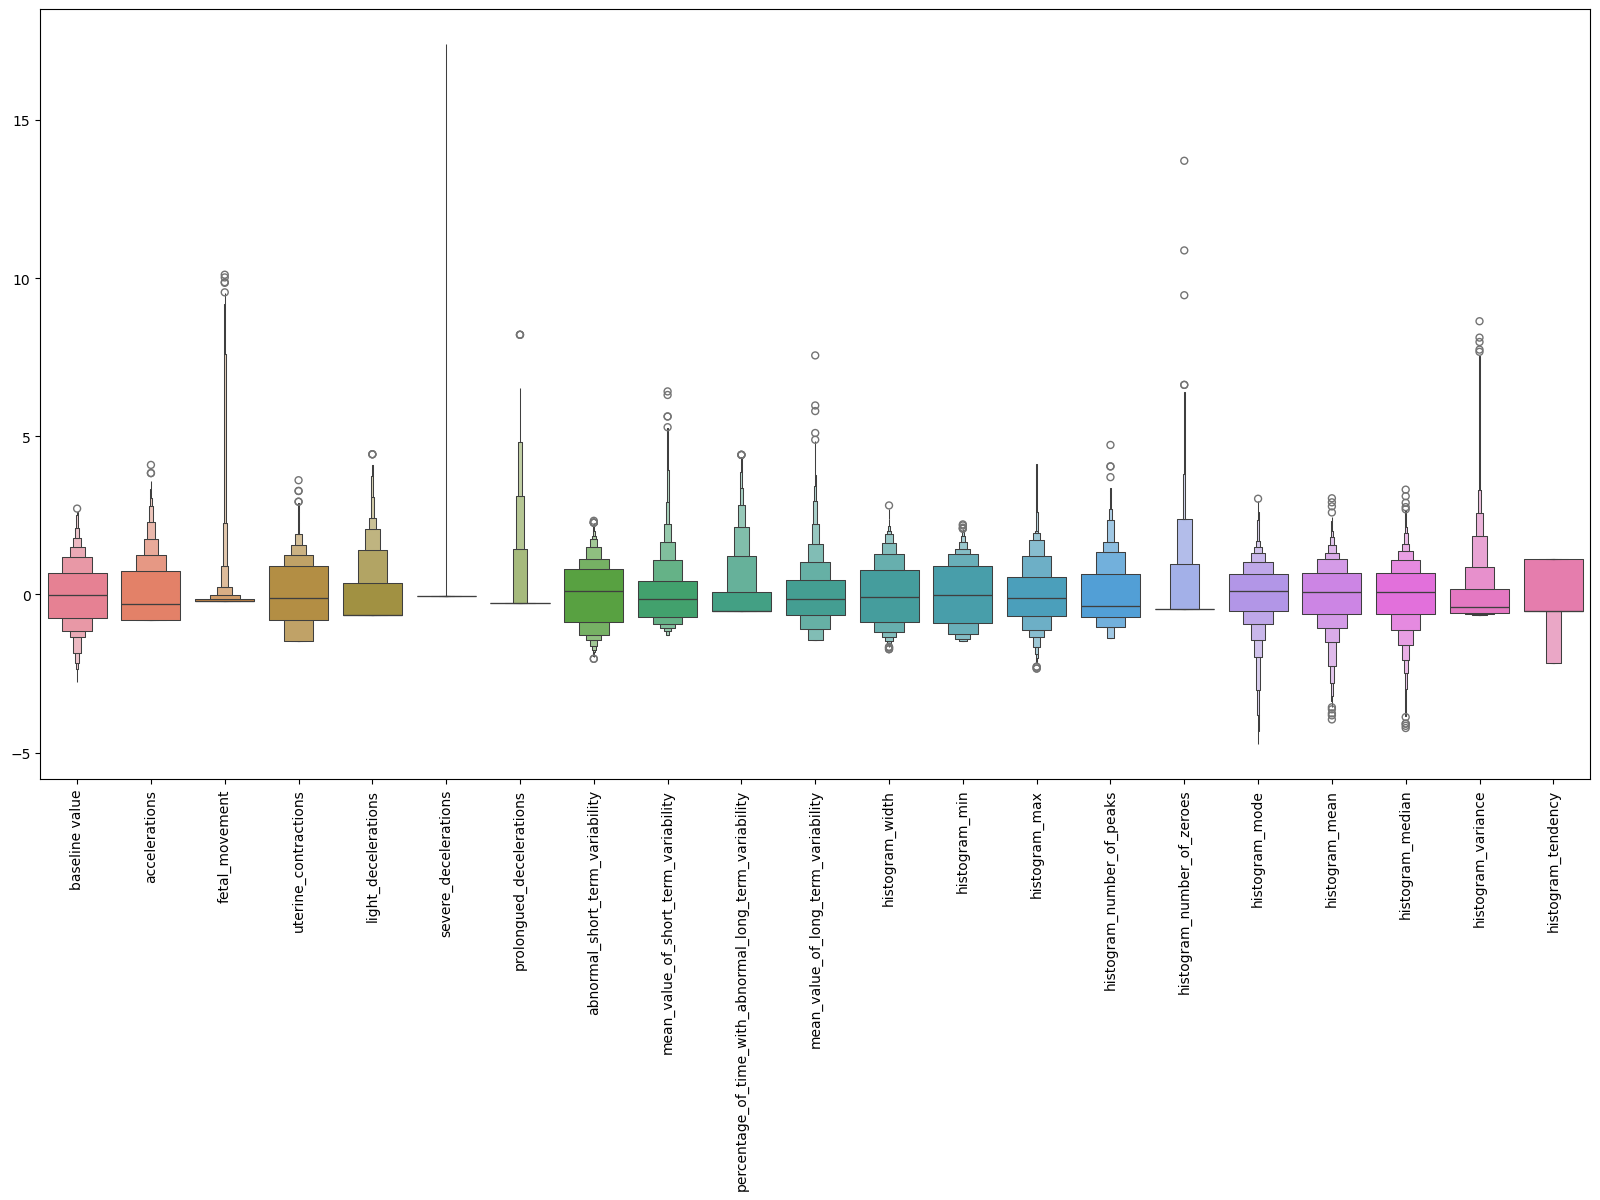

In [35]:
# Display scaled features
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_df)
plt.xticks(rotation=90)
plt.show()

## **4. Model**

### 4.1 Model Selection & Building

In [54]:
# Spliting training and test sets
X_train, X_test, y_train,y_test = train_test_split(X_df, y, test_size=0.3, random_state=42)

In [55]:
# A quick model selection process
pipeline_dt=Pipeline([ ('dt_regressor',DecisionTreeRegressor(random_state=RANDOM))])

pipeline_rf=Pipeline([('rf_regressor',RandomForestRegressor(random_state=RANDOM))])

pipeline_sv=Pipeline([('sv_regressor',SVR())])

pipelines = [pipeline_dt, pipeline_rf, pipeline_sv]

pipe_dict = {0: 'Decision Tree', 1: 'RandomForest', 2: "SVR"}

In [61]:
# Fit the pipelines
for pipe in tqdm.tqdm(pipelines):
    pipe.fit(X_train, y_train)

# Cross validation on accuracy 
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train, cv=10 )
    cv_results_accuracy.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

print("\n")

for i, model in enumerate(pipelines):
    cv_score_mae = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    cv_score_mse = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

    print(f"{pipe_dict[i]}: Mean MSE: {-cv_score_mse.mean():.5f} | Mean MAE: {-cv_score_mae.mean():.5f}")

100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


Decision Tree: 0.949586 
RandomForest: 0.982313 
SVR: 0.970888 


Decision Tree: Mean MSE: 0.30833 | Mean MAE: 0.38849
RandomForest: Mean MSE: 0.10901 | Mean MAE: 0.22176
SVR: Mean MSE: 0.19531 | Mean MAE: 0.15590


So Random Forest does best amongst the models to be the most accurate.

We will now build a better random forest with grid search cv and see how performs on test set

In [62]:
# Predict on the test set using RandomForestRegressor
pred_rfc = pipeline_rf.predict(X_test)

# Calculate the MSE and R-squared for the predictions
mse = mean_squared_error(y_test, pred_rfc)
mae = mean_absolute_error(y_test, pred_rfc)

print(f"MSE of RandomForestRegressor on test set: {mse:.5f}")
print(f"MAE of RandomForestRegressor on test set: {mae:.5f}")

MSE of RandomForestRegressor on test set: 0.08735
MAE of RandomForestRegressor on test set: 0.21273


### 4.2 Hyperparameter Tuning

### **WARNING WARNING WARNING**

The following cells takes on average 3 hours to complete. **RUN IT ONLY WHEN YOU NEED TO**

In [72]:
# # Build a dictionary with list of parameter values that can be analysed by GridSearch CV
# parameters = { 
#     'n_estimators': [100, 150, 200, 500, 700, 900],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4, 6, 8, 12, 14, 16],
#     'criterion' :['squared_error', 'absolute_error'],
#     'n_jobs':[-1, 1, None]
# }

# #Fitting the training set to find parameters with best accuracy
# CV_rfc = GridSearchCV(estimator=RandomForestRegressor(random_state=RANDOM), param_grid=parameters, cv=5, verbose=3)
# CV_rfc.fit(X_train, y_train)

# # # Getting the best parameters from the gridsearch
# best_param = CV_rfc.best_params_
# best_param

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV 1/5] END criterion=squared_error, max_depth=4, max_features=auto, n_estimators=100, n_jobs=-1;, score=0.921 total time=   0.2s
[CV 2/5] END criterion=squared_error, max_depth=4, max_features=auto, n_estimators=100, n_jobs=-1;, score=0.920 total time=   0.1s
[CV 3/5] END criterion=squared_error, max_depth=4, max_features=auto, n_estimators=100, n_jobs=-1;, score=0.921 total time=   0.1s
[CV 4/5] END criterion=squared_error, max_depth=4, max_features=auto, n_estimators=100, n_jobs=-1;, score=0.935 total time=   0.1s
[CV 5/5] END criterion=squared_error, max_depth=4, max_features=auto, n_estimators=100, n_jobs=-1;, score=0.947 total time=   0.1s
[CV 1/5] END criterion=squared_error, max_depth=4, max_features=auto, n_estimators=100, n_jobs=1;, score=0.921 total time=   0.2s
[CV 2/5] END criterion=squared_error, max_depth=4, max_features=auto, n_estimators=100, n_jobs=1;, score=0.920 total time=   0.2s
[CV 3/5] END criterio

{'criterion': 'squared_error',
 'max_depth': 16,
 'max_features': 'sqrt',
 'n_estimators': 500,
 'n_jobs': -1}

In [74]:
best_param

{'criterion': 'squared_error',
 'max_depth': 16,
 'max_features': 'sqrt',
 'n_estimators': 500,
 'n_jobs': -1}

In [78]:
# Now, train the model using the best parameters identified
best_rfc = RandomForestRegressor(**best_param, random_state=RANDOM)
best_rfc.fit(X_train, y_train)
y_pred = best_rfc.predict(X_test)

# Calculate regression metrics to evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

MSE: 0.0585388028185785
RMSE: 0.24194793410686213
MAE: 0.17127532235386347
R2: 0.9897685096582874


## 5. Visualisation of Result

### 5.1 Residual Plot

* Shows the difference between observed and predicted values.
* y-axis represents the residuals, which are the differences between the actual and predicted values.
    * Points above the horizontal line (residuals = 0) indicate under-predictions and points below the line indicate over-predictions.
* The red dashed line at residuals = 0 acts as a reference point. Ideally, the residuals should be symmetrically distributed around this line, indicating unbiased predictions.

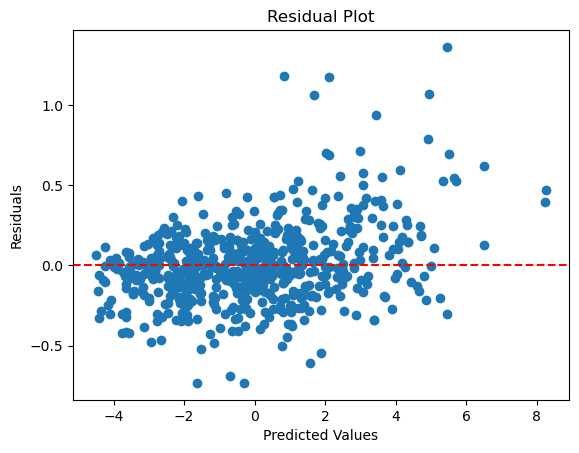

In [79]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

* The points are randomly scattered around the horizontal line, it suggests a good fit for the model.
* The residuals are mostly close to the line, the model's predictions are generally accurate. 

### 5.2 Prediction Error Plot

* Compares the actual target values against the predictions to show how much the prediction deviates from the reality.

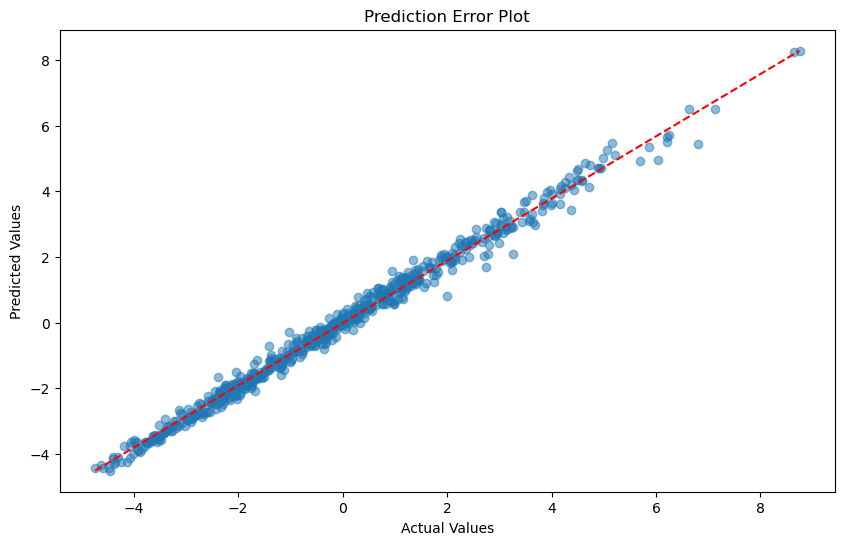

In [82]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], '--r')
plt.title('Prediction Error Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

### 5.3 Feature Importance Plot

* Shows which features contribute more to the prediction

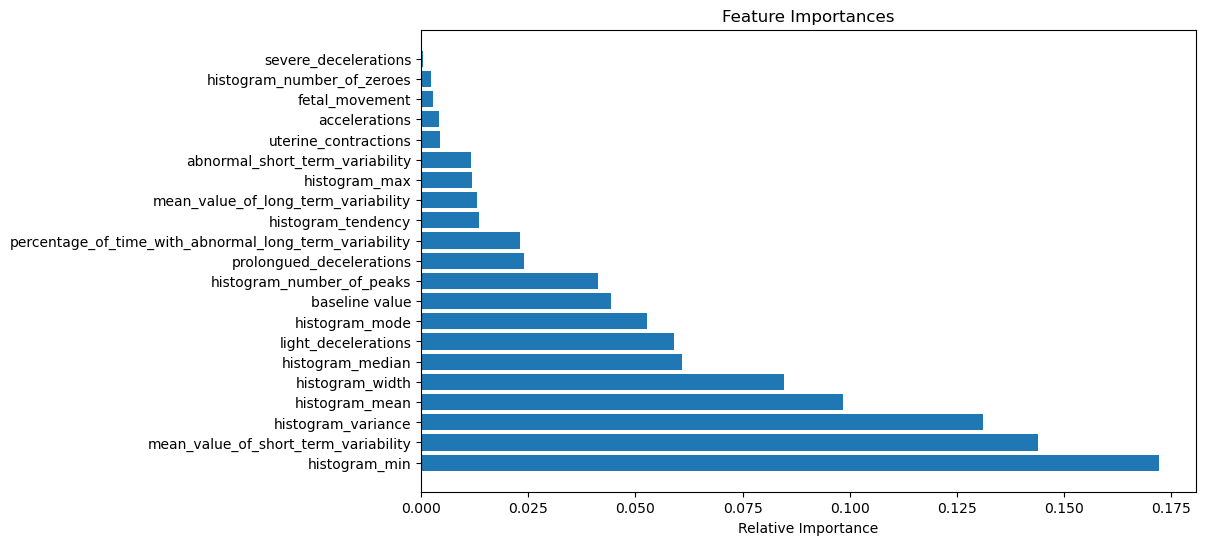

In [83]:
feature_importances = best_rfc.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(X_train.shape[1]), feature_importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 5.4 Learning Curve

* Shows the model’s performance over time as more data is used for training.
* Indicate if the model would benefit from more data or if it's overfitting or underfitting.

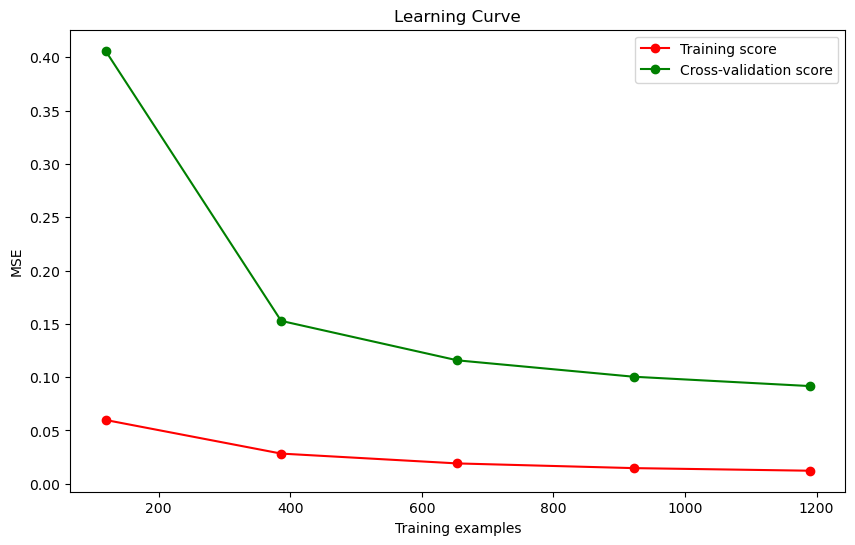

In [86]:
train_sizes, train_scores, test_scores = learning_curve(best_rfc, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
train_error_mean = -np.mean(train_scores, axis=1)
test_error_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_error_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_error_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('MSE')
plt.legend(loc="best")
plt.show()